In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

notebook_num = 5
path = 'models/'+str(notebook_num)
%load_ext autoreload
%autoreload 2
import utils
from utils import *


Using TensorFlow backend.
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


AttributeError: module 'pandas.core.computation' has no attribute 'expressions'

In [ ]:
train_x, valid_x, test_x, train_y, valid_y = load_train_valid_test_data('train.csv','test.csv',0.2)

In [6]:
validate_preprocessing(train_x, valid_x, test_x, train_y, valid_y)

max train 1.0
max valid 1.0
max test 1.0
train_x shape (33600, 28, 28, 1)
valid_x shape (8400, 28, 28, 1)
test_x shape (28000, 28, 28, 1)
train_y shape (33600, 10)
valid_y shape (8400, 10)


## Defining a good model

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model
from keras import optimizers
from keras import regularizers
from keras.layers.core import Dense, Activation# defining the layers
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten
from keras.optimizers import RMSprop, SGD , Adam
from keras.utils import np_utils
from keras import backend as K
from keras.models import clone_model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.utils import  to_categorical


def CNN_model_psuedolabeling(optimizer,epochs,train_x,train_y,valid_x = None,valid_y = None,drop_out = 0.5):
    cnn_model = CNN_architecture(True,drop_out)
    history_list = []
    train_generator = data_augmentation_generator(train_x,train_y, batch_size = 64)
    batch_size = 64
    steps_per_epoch = int(train_x.shape[0]/batch_size)
    for i in range(4):
        print('schedule #',i)
        optimizer = Adam(lr= 0.001)
        cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,#RMSprop()
                      metrics=['accuracy'])
        
        cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,#RMSprop()
                      metrics=['accuracy'])
        history = cnn_model.fit_generator(train_generator,epochs=int(epochs*2/3),
                            verbose=1,validation_data=(valid_x, valid_y),steps_per_epoch= steps_per_epoch)
        history_list.append(history)
        optimizer = Adam(lr= 0.0001)
        cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,#RMSprop()
                      metrics=['accuracy'])
        history = cnn_model.fit_generator(train_generator,epochs=int(epochs*2/3),
                            verbose=1,validation_data=(valid_x, valid_y),steps_per_epoch= steps_per_epoch)
        history_list.append(history)
    print('final stage')
    print('')
    print('')
    optimizer = Adam(lr= 0.00001)
    cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,#RMSprop()
                  metrics=['accuracy'])
    history = cnn_model.fit_generator(train_generator,epochs=int(epochs*2/3),
                        verbose=1,validation_data=(valid_x, valid_y),steps_per_epoch= steps_per_epoch)

    history_list.append(history)
    return cnn_model, history_from_list(history_list)

def CNN_after_psuedo_labeling(cnn_model,epochs,train_x,train_y,valid_x = None,valid_y = None,test_x = None ):
    predictions = model.predict(test_x)
    predictions = predictions.max(axis = 1)
    #enc.fit(predictions.reshape((predictions.shape[0],1)),10)
    test_y = to_categorical(predictions,10)
    train_x = np.vstack((train_x,train_x))
    train_x = np.vstack((train_x,test_x))
    train_y = np.vstack((train_y,train_y))
    train_y = np.vstack((train_y,test_y))
    print(train_x.shape,train_y.shape)
    
    history_list = []
    for i in range(4):
        print('schedule #',i)
        optimizer = Adam(lr= 0.001)
        cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,#RMSprop()
                      metrics=['accuracy'])
        
        cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,#RMSprop()
                      metrics=['accuracy'])
        history = cnn_model.fit(train_x,train_y,
                        batch_size = 64,epochs=int(epochs*2/3),
                        verbose=1,validation_data=(valid_x, valid_y))
        history_list.append(history)
        optimizer = Adam(lr= 0.0001)
        cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,#RMSprop()
                      metrics=['accuracy'])
        history = cnn_model.fit(train_x,train_y,
                        batch_size = 64,epochs=int(epochs*2/3),
                        verbose=1,validation_data=(valid_x, valid_y))
        history_list.append(history)
    print('final stage')
    print('')
    print('')
    optimizer = Adam(lr= 0.00001)
    cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,#RMSprop()
                  metrics=['accuracy'])
    history = cnn_model.fit(train_x,train_y,
                        batch_size = 64,epochs=int(epochs*2/3),
                        verbose=1,validation_data=(valid_x, valid_y))

    history_list.append(history)
    return cnn_model, history_from_list(history_list)
    

In [30]:
drop_outs = [0.45]#,0.5,0.55]
ensemble_models = []
ensemble_histories = []
optimizer = 'adam'
n_epochs = 20
model,history = CNN_model_psuedolabeling(optimizer,n_epochs, train_x, train_y, valid_x, valid_y,drop_out = drop_outs[0])



schedule # 0
Epoch 1/13
 77/525 [===>..........................] - ETA: 17s - loss: 2.1962 - acc: 0.3202

KeyboardInterrupt: 

In [19]:
model.save(path + '_drop_'+ str(drop_outs[0])+'_sche=4'+''+'psuedolabel' +'_before.h')
generate_submission(model,test_x,'5-sub_adam_cnn_aug_schedule_4_tr9965_val9962_before_pseudolabel.csv',['ImageId','Label'])

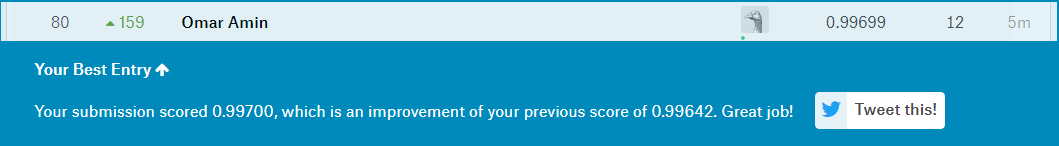

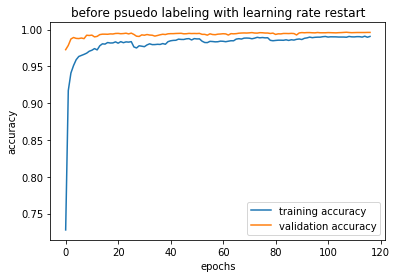

In [18]:
fig = plt.figure()
hist1 = history.history['acc']
hist2 = history.history['val_acc']
#hist3 = adam_history.history['acc']
plt.title('before psuedo labeling with learning rate restart')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(hist1,label='training accuracy')
plt.plot(hist2,label='validation accuracy')
plt.legend()
plt.show()
fig.savefig('5-best_ensemble_schedule_restart.png')



## Pseudo-Labeling

In [8]:
model = load_model(path + '_drop_'+ str(0.45)+'_sche=4'+''+'psuedolabel' +'_before.h')

In [10]:
preds = model.predict(valid_x)
print(np.sum(np.argmax(preds,axis = 1)  == np.argmax(valid_y,axis = 1))*1.0/valid_y.shape[0])

0.99619047619


In [11]:
model, history = CNN_after_psuedo_labeling(model,10,train_x=train_x,train_y=train_y,valid_x = valid_x,valid_y= valid_y,test_x=test_x)

(95200, 28, 28, 1) (95200, 10)
schedule # 0
Train on 95200 samples, validate on 8400 samples
Epoch 1/6
95200/95200 [==============================] - 30s 312us/step - loss: 0.8401 - acc: 0.6901 - val_loss: 0.2846 - val_acc: 0.9896
Epoch 2/6
95200/95200 [==============================] - 29s 305us/step - loss: 0.6031 - acc: 0.7155 - val_loss: 0.2750 - val_acc: 0.9904
Epoch 3/6
95200/95200 [==============================] - 29s 302us/step - loss: 0.5906 - acc: 0.7219 - val_loss: 0.2799 - val_acc: 0.9908
Epoch 4/6
95200/95200 [==============================] - 29s 303us/step - loss: 0.5848 - acc: 0.7242 - val_loss: 0.2844 - val_acc: 0.9923
Epoch 5/6
95200/95200 [==============================] - 29s 303us/step - loss: 0.5791 - acc: 0.7264 - val_loss: 0.3327 - val_acc: 0.9900
Epoch 6/6
95200/95200 [==============================] - 29s 309us/step - loss: 0.5777 - acc: 0.7278 - val_loss: 0.3387 - val_acc: 0.9911
Train on 95200 samples, validate on 8400 samples
Epoch 1/6
95200/95200 [=======

NameError: name 'train_generator' is not defined

In [14]:
print(predictions.shape)
predictions = predictions.max(axis = 1)
#enc.fit(predictions.reshape((predictions.shape[0],1)),10)
labels = to_categorical(predictions,10)
print(predictions.shape,labels[0,:])

(28000, 10)
(28000,) [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


## New heading

In [77]:
generate_submission(models[-2],test_x,'sub_adam_cnn_2c_1p_2c_1p_train9965_valid9962_batch_lrannealing.csv',['ImageId','Label'])

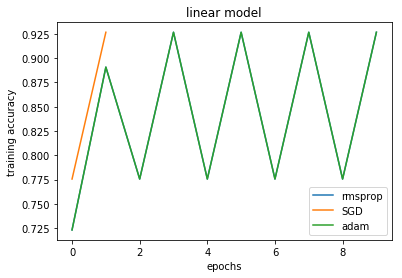

0.926517857143 0.842172619048


In [33]:
plt.figure()

hist1 = ensemble_models[0].history['acc']
hist2 = ensemble_models[1].history['acc']
h = history_appending(ensemble_models[0],ensemble_models[1])
hist3 = ensemble_models[2].history['acc']
plt.title('linear model')
plt.xlabel('epochs')
plt.ylabel('training accuracy')
plt.plot(hist1,label='rmsprop')
plt.plot(hist2,label='SGD')
plt.plot(h.history['acc'],label='adam')
plt.legend()
plt.show()
print(hist1[-1],hist3[-1])

In [139]:
predictions.shape
result = predictions.argmax(axis =1 )
result.shape
result = result.reshape((28000,1))
ids = (np.arange(28000)+1).reshape((28000,1))
result = np.hstack((ids,result))
print(result[:4,:],result.shape)
m = to_kaggle_csv(result,['ImageId','Label'],'submission_adam_model_300ep_no_regularization.csv')
print(m.head())
#plt.imshow(test_x[3,:].reshape((28,28)))
#plt.show()

[1 2 3 4]
[[1 2]
 [2 0]
 [3 9]
 [4 7]] (28000, 2)
   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      7
4        5      3
